## 0. 환경세팅하기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1. 준비한 이미지를 불러옵니다

이번 exploration을 진행하며 필요한 패키지들은 opencv, cmake, dlib 입니다. 없으니 ```pip install``` 로 설치해줍니다.
찾아보니 opencv는 **실시간 이미지 처리**에 적합한 라이브러리라고 하네요. 지금 공부하고 있는 예제는 사진에 국한되어 있지만 영상은 움직이는 사물

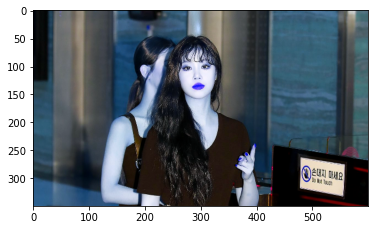

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (600, 350))    
img_show = img_bgr.copy()    
plt.imshow(img_bgr)
plt.show()

## 2. BGR이미지를 RGB 이미지로 변환해줍니다   
oopencv는 BGR 이미지 채널을 사용하므로 이를 RGB이미지로 변환해줍니다. 

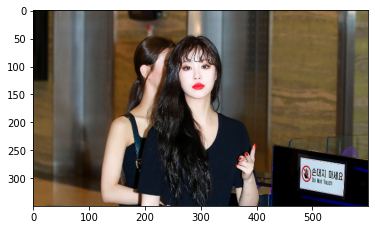

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #이미지 색상 변환 코드
plt.imshow(img_rgb) #이미지 출력
plt.show()

## 3. 얼굴 검출하기

Object detection이라는 기술을 사용해서 얼굴을 찾아줍니다. dlib을 활용하여 hog detector 선언

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 3)   

rectangles[[(256, 86) (323, 153)]]


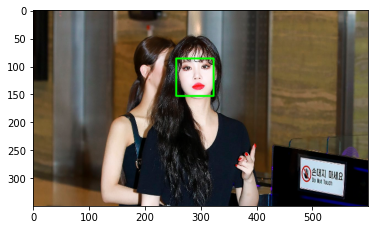

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표를 화면에 출력한다

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 랜드마크 구성해주기

top-down : bounding box를 찾고 box 내부의 keypoint를 예측 하는 방식으로 찾아줍니다.


In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(len(list_landmarks))

68
1


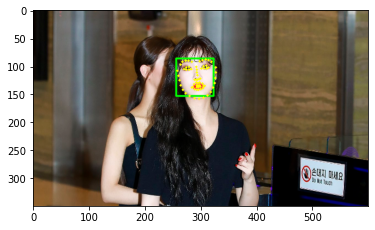

In [9]:
#이미지 위에 랜드마크를 출력해준다
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 좌표확인   
얼굴 어떤 위치에 스티커를 위치시킬지 확인하기 위해 좌표를 확인해줍니다. 랜드마크의 위치까지는 잘 잡아줬는데 왜 //2 등을 하는지 이해하지 못해서 팀원들과 한참을 고민하고 그림도 그리면서 서로 설명하는 시간을 가졌습니다. 좌표계에 익숙하지 않아서 더 어려웠다.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[0][0]
    y = landmark[0][1] + dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(294, 116)
(x,y) : (258,142)
(w,h) : (68,68)


In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(68, 68, 3)


In [12]:
refined_x = x  # left
refined_y = (y - h) // 2      #
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (258,37)


## 5. 스티커 적용   
예제에서 refined_y = 0 일때 top의 y 좌표가 이미지의 경계값으로 설정된다고 했다. 나 같은 경우에는 이미지의 top 좌표가 얼굴 중앙에 왔으면 해줬기 때문에 refined_y = 90으로 수정을 해줬다. 스티커가 얼굴 아래로 내려오지 않아서 몇시간을 헤맸습니다.

In [13]:
refined_y = 90
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (258,90)


In [14]:
#스티커를 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

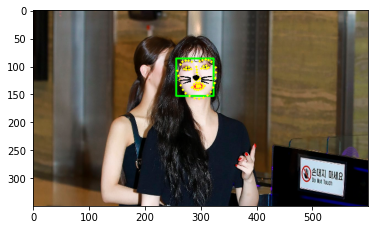

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 최종결과 출력

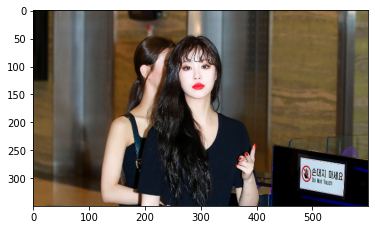

In [16]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 다양한 변수에 따른 영향도 평가해보기
# <다양한 각도 적용해보기>

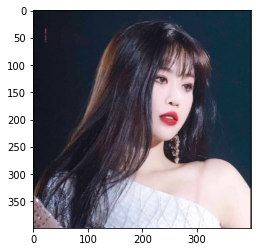

In [17]:
#일단 새 이미지를 불러와봅니다.
#이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Screenshot from 2021-01-16 17-53-34.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (400, 399))    
img_show = img_bgr.copy() 
#이미지 불러와서 색상 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb) #이미지 출력
plt.show()

In [18]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 3)   

In [19]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

68


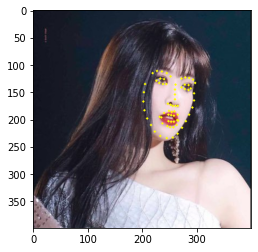

In [20]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 좌표확인

In [21]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(260, 163)
(x,y) : (260,211)
(w,h) : (97,97)


In [22]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(97, 97, 3)


In [23]:
refined_x = x - w//2  # left
refined_y = (y - h) // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (212,57)


## 이미지적용

In [24]:
refined_y = 124
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (212,124)


In [25]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

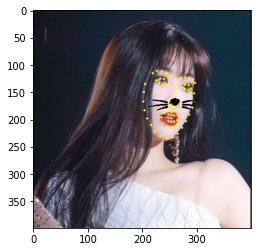

In [26]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 중간 평가
잘 적용이 됐네요! 여기까지는 어렵지 않았어요. 다만 첫 시도에서는 landmark 0번을 활용했었는데 이번 사진에서는 같은 랜드마크와 비율을 적용하니 수염의 위치가 완전히 어긋나버렸어요.    
스티커앱이면 사진이 얼굴에 맞춰 알아서 적용되어야 할텐데 landmark 0을 활용했을 때 어긋나므로   
**landmark 30** 을 이용해서 비율을 다시 계산해줍니다. 
```
refined_x = x - w//2  # left
refined_y = (y - h) // 2   # top
```
이번에는 위와 같이 수염을 배치해봅니다. 다른 사진에도 제대로 작동하는지 확인해볼까요?

## 스티커 위치 재확인

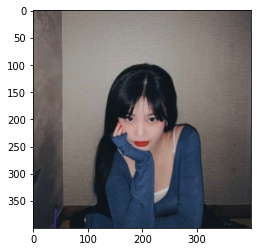

rectangles[[(156, 184) (237, 264)]]


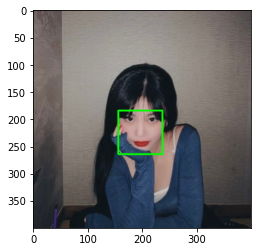

68


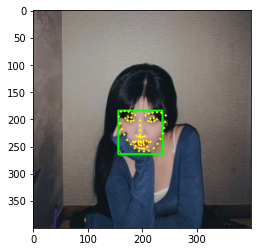

(196, 229)
(x,y) : (196,270)
(w,h) : (82,82)
(82, 82, 3)
(x,y) : (155,94)
(x,y) : (155,190)


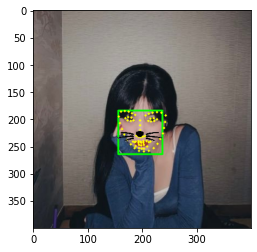

In [27]:
#위의 설정값이 원하는 방식으로 작동하는지 확인하기 위해 다른 사진을 불러옵니다.

import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cd.jpg'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (400, 400))    
img_show = img_bgr.copy() 
#이미지 불러와서 색상 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb) #이미지 출력
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 3)   

print(dlib_rects)   # 찾은 얼굴영역 좌표를 화면에 출력한다

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

refined_x = x - w//2  # left
refined_y = (y - h) // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

refined_y = 190
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()    

## 중간평가   
약간 어긋남이 있기는 하지만 대체로 잘 맞네요! 그래도 여전히 y값은 임의로 조정해줘야 한다는 문제가 있습니다.   

## 옆 모습    
이미지 인식기가 어디까지 인식을 할 수 있나 궁금하니 다른 사진을 더 불러와봅니다. 옆모습이에요.

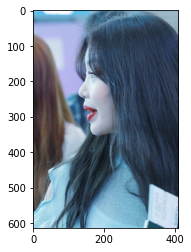

In [28]:
#이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/side.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (410, 614))    
img_show = img_bgr.copy() 
#이미지 불러와서 색상 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb) #이미지 출력
plt.show()

In [29]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 3)   

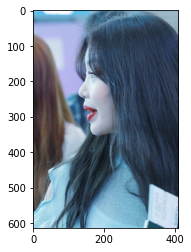

In [30]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()    

## 중간평가
   온전한 측면은 인지를 하지 못한다. 랜드마크를 찍어놓은 모델과 박스가 눈 두개 코 끝 그리고 입술을 기준으로 인식하기 때문인 것 같다. 조금 더 찾아보니 hog detector는 온전한 옆모습과 다양한 각도의 얼굴은 인지에 한계가 있다고 한다. [참고](https://towardsdatascience.com/cnn-based-face-detector-from-dlib-c3696195e01c) 이 블로그에서는 대안으로  CNN based face detector from dlib을 제시한다. 얼굴 인식기를 만드는데 다양한 방법을 활용할 수 있음을 알게 되었습니다. 그러고보니 스티커 사진 앱을 사용할때도 간혹 스티커가 사라질때가 있었던 것 같아요. 옆모습은 스티커를 붙이기도 어렵죠. 고양이 수염이 아니라 모자같은거라면 조금 더 쉬울까요.

## 두명의 사진   
hog detector가 두 사람의 얼굴도 잘 인식할까요? 궁금하니까 두명도 진행해봅니다. 

In [31]:
#이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/two.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (690, 370))    
img_show = img_bgr.copy()    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 

rectangles[[(195, 180) (334, 319)], [(327, 87) (493, 254)]]


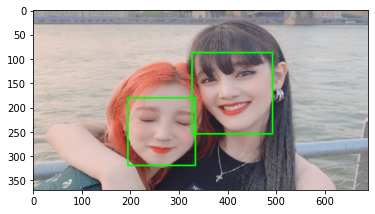

In [32]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 3)   

print(dlib_rects)   # 찾은 얼굴영역 좌표를 화면에 출력한다

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

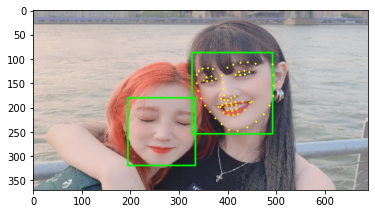

In [33]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

잘 인식하네요. 다만 문제가 생겼습니다    
**한명 분의 랜드마크만 형성되네요. 가장 오른쪽에 있는 사람에게만 형성되는 걸 보니 랜드마크는 오른쪽 사람부터 인식해서 찍히나봐요.**
어떤 변수를 수정해야 두 사람을 인식할까요. 찾아보기로 합니다.

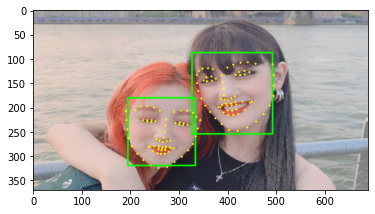

In [34]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()    
      
        
# 질문 방에 올려봤느데 landmark predictor를 호출하는 함수에서 bounding box나 point를 조절해보라고 한다. 시도해보기로 합니다
#lamda q: (q.x, q.y) 추가해봤는데 안됩니다 invalid syntax error가 난다. 이건 아닌가봐요

#랜드마크를 인지해야할 리스트를 프린트해봤는데 2가 나온다. 
#2명을 잘 인식했다는 뜻인데 왜 그럼에도 바운딩 박스에 안에 랜드마크가 제대로 붙지않을까요.
#다른 분의 도움으로 해결했습니다. lms상의 코드가 틀렸다고 하네요
    

## 코드 수정

```python
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
```

라는 코드에서 **point in enumerate(list_points)** 라는 코드를 **point in enumerate(landmark)** 로 수정하니   
정상적으로 작동하네요.ennumerate가 열거하라는 뜻인데 포인트의 리스트를 나열할때와 랜드마크를 나열하는건 왜 이렇게 다른 결과를 출력할까요. 

In [35]:
# 랜드마크를 찾았으니 스티커를 붙여봅니다.
## 좌표확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(269, 261)
(x,y) : (269,331)
(w,h) : (140,140)
(393, 175)
(x,y) : (393,258)
(w,h) : (167,167)


In [36]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)


refined_x = x - w//2  # left
refined_y = (y - h) // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

refined_y = 100
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


#이미지가 마지막으로 실행된 w,h인 167에 맞추어 리사이즈 된다

(167, 167, 3)
(x,y) : (310,45)
(x,y) : (310,100)


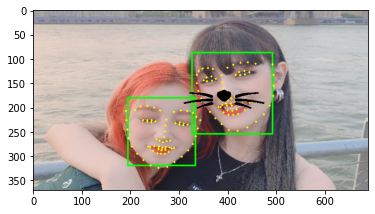

In [37]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 문제 발생   
이번에는 스티커가 하나만 생성이 된다. 위치도 애매한 것 같다. 두 사람에게 다 스티커를 적용하려면 어떻게 해결해야할까? 바운딩 박스를 오른쪽에서부터 인식하니 아마 마지막에 인식한 왼쪽 사람의 바운딩박스 크기에 맞춰 스티커가 리사이즈 된 후 그 스티커만 사진에 적용되고 있는 것 같다.

----

# 한계점   

1. **본래 스티커 앱이라면 스티커가 얼굴 크기에 맞게 리사이징이 진행되어야 한다.**
2. **x 값이나 y값을 조정할 필요 없이 지정된 위치(비율)에 맞게 스티커가 합성되어야 한다.**
3. **더 다양한 얼굴 각도를 재빠르게 인식할 수 있어야한다.**
4. **두 사람 이상의 얼굴을 인식하고 인원수에 맞게 스티커를 부착할 수 있어야한다**

---
### 시도  

1번 : opencv의 이미지 processing 기능을 검색해도 이미지의 비율을 바꾸는 코드는 찾지 못했다. 다른게 있을까.
2번 : 랜드마크가 아니라 얼굴 **중앙 축**을 따라 스티커를 부착하는 방법이 있다는 걸 찾았지만 능력 부족으로 실행하지는 못했다.
3번 : 영상 처리의 경우 CNN기반의 detector가 더 빠르다는 걸 알아냈다. 언젠가 영상 처리에 사용할 날이 오겠지.
4번 : 5섯명까지 얼굴을 인식시키는 건 성공했지만 스티커를 모두에게 붙이는 건 성공하지 못했다. 


# [E3] 후기
E3에서는 가장 기초적인 단계의 스티커 앱을 제작해 보았다. **opencv로 이미지를 불러오는 법, RGB로 이미지를 변환하는 법, dlib을 활용해서 HOG를 선언하는 법, landmark를 출력하는 법** 등을 알 수 있었다. 다만 스티커앱이라 부르기에는 부족함이 많아 아쉬움이 남는다. 개선을 위한 시도들은 #중간평가 #문제발생 #한계점에 적어두었다. 아직 아는 것이 별로 없어 시도에 비해 수확이 없는것이 아쉽다. 
